In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 17.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import cv2

image_path = "/kaggle/input/sportsmot/sportsmot_publish/dataset/train/v_-6Os86HzwCs_c001/img1/000001.jpg"
image = cv2.imread(image_path)
height, width, _ = image.shape

print(f"Width: {width}, Height: {height}")

Width: 1280, Height: 720


In [3]:
import os
import random
import shutil
import pandas as pd
import yaml

SOURCE_DIR_TRAIN = "/kaggle/input/sportsmot/sportsmot_publish/dataset/train"
SOURCE_DIR_VAL = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val"
TARGET_DIR = "/kaggle/working/yolo_dataset/"

YOLO_DIRS = {
    "train": {
        "images": os.path.join(TARGET_DIR, "images/train"),
        "labels": os.path.join(TARGET_DIR, "labels/train"),
    },
    "val": {
        "images": os.path.join(TARGET_DIR, "images/val"),
        "labels": os.path.join(TARGET_DIR, "labels/val"),
    }
}

for split in YOLO_DIRS.values():
    os.makedirs(split["images"], exist_ok=True)
    os.makedirs(split["labels"], exist_ok=True)

def convert_mot_to_yolo(mot_annotations, img_width, img_height):
    yolo_annotations = []
    for _, row in mot_annotations.iterrows():
        x, y, w, h = row[2], row[3], row[4], row[5]
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        w = w / img_width
        h = h / img_height
        yolo_annotations.append(f"0 {x_center} {y_center} {w} {h}\n")
    return yolo_annotations

def process_dataset_split(source_dir, yolo_dirs):
    video_folders = [os.path.join(source_dir, folder) for folder in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, folder))]

    for video_folder in video_folders:
        img_folder = os.path.join(video_folder, "img1")
        gt_file = os.path.join(video_folder, "gt/gt.txt")

        if not os.path.exists(img_folder) or not os.path.exists(gt_file):
            continue

        image_files = sorted([f for f in os.listdir(img_folder) if f.endswith(".jpg")])

        selected_images = random.sample(image_files, min(40, len(image_files)))

        columns = ["frame", "track_id", "x", "y", "w", "h", "conf", "class", "visibility"]
        df = pd.read_csv(gt_file, names=columns)

        for img in selected_images:
            img_path = os.path.join(img_folder, img)
            frame_number = int(img.split('.')[0])

            frame_annotations = df[df["frame"] == frame_number]

            if not frame_annotations.empty:
                yolo_annotations = convert_mot_to_yolo(frame_annotations, 1280, 720)

                yolo_label_path = os.path.join(yolo_dirs["labels"], img.replace(".jpg", ".txt"))
                with open(yolo_label_path, "w") as f:
                    f.writelines(yolo_annotations)

                shutil.copy(img_path, os.path.join(yolo_dirs["images"], img))

process_dataset_split(SOURCE_DIR_TRAIN, YOLO_DIRS["train"])
process_dataset_split(SOURCE_DIR_VAL, YOLO_DIRS["val"])

data_yaml = {
    "train": os.path.abspath(YOLO_DIRS["train"]["images"]),
    "val": os.path.abspath(YOLO_DIRS["val"]["images"]),
    "nc": 1,
    "names": ["person"]
}

with open(os.path.join(TARGET_DIR, "data.yaml"), "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("✅ Dataset successfully converted for YOLO fine-tuning with 20 random images per video!")


<ipython-input-3-58a871dfc12e>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x, y, w, h = row[2], row[3], row[4], row[5]  # Extract bounding box
<ipython-input-3-58a871dfc12e>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x, y, w, h = row[2], row[3], row[4], row[5]  # Extract bounding box
<ipython-input-3-58a871dfc12e>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x, y, w, h = row[2], row[3], row[4], row[5]  # Extract bo

✅ Dataset successfully converted for YOLO fine-tuning with 20 random images per video!


In [4]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import json

DATASET_PATH = "/kaggle/working/yolo_dataset/data.yaml"

model = YOLO("yolov8m.pt")

results = model.train(
    data=DATASET_PATH,
    epochs=15,
    imgsz=640,
    batch=16,
    device="cuda",
    project="/kaggle/working/yolo_training_15_epoch",
    name="fine_tuned_yolo",
    verbose=True
)

print("\n✅ Fine-tuning complete! Model saved in /kaggle/working/yolo_training/fine_tuned_yolo/")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 257MB/s]


Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/kaggle/working/yolo_training_15_epoch, name=fine_tuned_yolo, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.5MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_dataset/labels/train... 731 images, 0 backgrounds, 0 corrupt: 100%|██████████| 731/731 [00:00<00:00, 961.03it/s] 

train: New cache created: /kaggle/working/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/yolo_dataset/labels/val... 726 images, 0 backgrounds, 0 corrupt: 100%|██████████| 726/726 [00:00<00:00, 808.39it/s] 

val: WARNING ⚠️ /kaggle/working/yolo_dataset/images/val/000670.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/images/val/000868.jpg: 1 duplicate labels removed
val: New cache created: /kaggle/working/yolo_dataset/labels/val.cache


Plotting labels to /kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolo_training_15_epoch/fine_tuned_yolo
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      6.71G      1.078     0.9599      1.037        274        640: 100%|██████████| 46/46 [00:23<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.03it/s]


                   all        726       7912      0.832      0.754      0.811      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      6.87G      1.028     0.6247     0.9965        213        640: 100%|██████████| 46/46 [00:22<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.45it/s]

                   all        726       7912      0.897      0.828      0.888      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      6.91G      1.029     0.6311      1.009        204        640: 100%|██████████| 46/46 [00:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.29it/s]

                   all        726       7912      0.904      0.888      0.938      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      6.79G      1.012     0.5997     0.9927        256        640: 100%|██████████| 46/46 [00:25<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.19it/s]

                   all        726       7912      0.908      0.873      0.924      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      6.88G     0.9806     0.5645     0.9804        241        640: 100%|██████████| 46/46 [00:26<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.28it/s]

                   all        726       7912      0.921      0.881      0.934      0.699


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      6.79G     0.9128     0.5451     0.9875        111        640: 100%|██████████| 46/46 [00:25<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.24it/s]

                   all        726       7912      0.901      0.899      0.938      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      6.85G     0.9539     0.5364     0.9944        112        640: 100%|██████████| 46/46 [00:25<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.21it/s]

                   all        726       7912        0.9      0.882      0.932      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      6.78G     0.9019     0.4996     0.9714        117        640: 100%|██████████| 46/46 [00:25<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.26it/s]

                   all        726       7912      0.914      0.888      0.936      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      6.85G      0.868     0.4884     0.9619        111        640: 100%|██████████| 46/46 [00:25<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.25it/s]

                   all        726       7912      0.923      0.925       0.95      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      6.83G     0.8276     0.4565     0.9473        117        640: 100%|██████████| 46/46 [00:25<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.24it/s]

                   all        726       7912      0.926      0.928      0.956      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      6.87G     0.8038     0.4374     0.9372        109        640: 100%|██████████| 46/46 [00:25<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.24it/s]

                   all        726       7912      0.933      0.918      0.956      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      6.81G     0.7882     0.4283     0.9311        124        640: 100%|██████████| 46/46 [00:25<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.25it/s]

                   all        726       7912      0.936       0.91      0.958      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      6.88G      0.756     0.4026     0.9225        105        640: 100%|██████████| 46/46 [00:25<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.25it/s]

                   all        726       7912      0.929      0.935      0.955      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      6.78G     0.7399     0.3949     0.9117        118        640: 100%|██████████| 46/46 [00:25<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.23it/s]

                   all        726       7912      0.941      0.941      0.959      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      6.86G     0.7202     0.3763     0.9018        104        640: 100%|██████████| 46/46 [00:25<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.21it/s]

                   all        726       7912      0.936       0.94      0.961      0.776



15 epochs completed in 0.140 hours.
Optimizer stripped from /kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/weights/last.pt, 52.0MB
Optimizer stripped from /kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/weights/best.pt, 52.0MB

Validating /kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]


                   all        726       7912      0.936      0.939      0.961      0.776


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 6.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/yolo_training_15_epoch/fine_tuned_yolo

✅ Fine-tuning complete! Model saved in /kaggle/working/yolo_training/fine_tuned_yolo/


In [5]:
from ultralytics import YOLO

# Load the fine-tuned model
model_path = "/kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/weights/best.pt"
model = YOLO(model_path)

print("✅ Fine-tuned YOLO model loaded successfully!")


✅ Fine-tuned YOLO model loaded successfully!



image 1/1 /kaggle/input/sportsmot/sportsmot_publish/dataset/train/v_-6Os86HzwCs_c001/img1/000001.jpg: 384x640 10 persons, 25.2ms
Speed: 1.8ms preprocess, 25.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


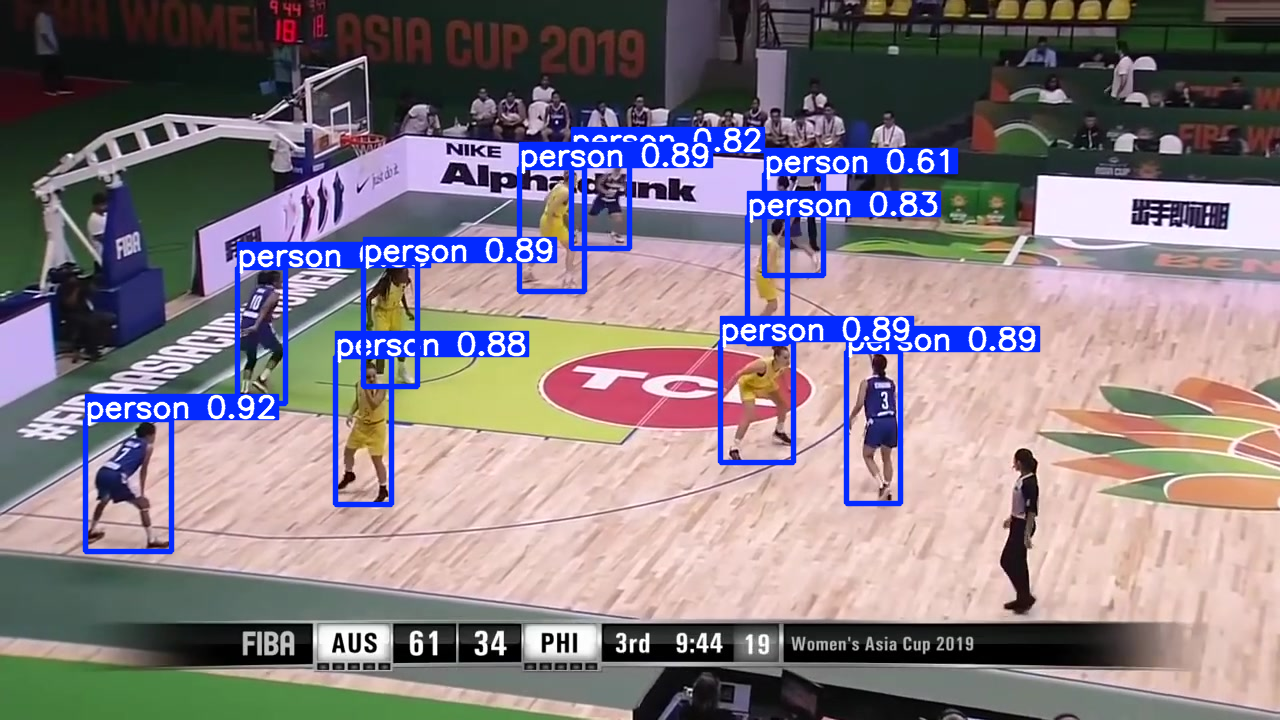

In [7]:
# Define the image path
image_path = "/kaggle/input/sportsmot/sportsmot_publish/dataset/train/v_-6Os86HzwCs_c001/img1/000001.jpg" # Change this to your test image

# Run inference
results = model.predict(image_path, save=True)

# Show the results
for result in results:
    result.show()  # Display the image with bounding boxes



image 1/1 /kaggle/input/sportsmot/sportsmot_publish/dataset/train/v_1LwtoLPw2TU_c016/img1/000001.jpg: 384x640 8 persons, 25.2ms
Speed: 1.7ms preprocess, 25.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


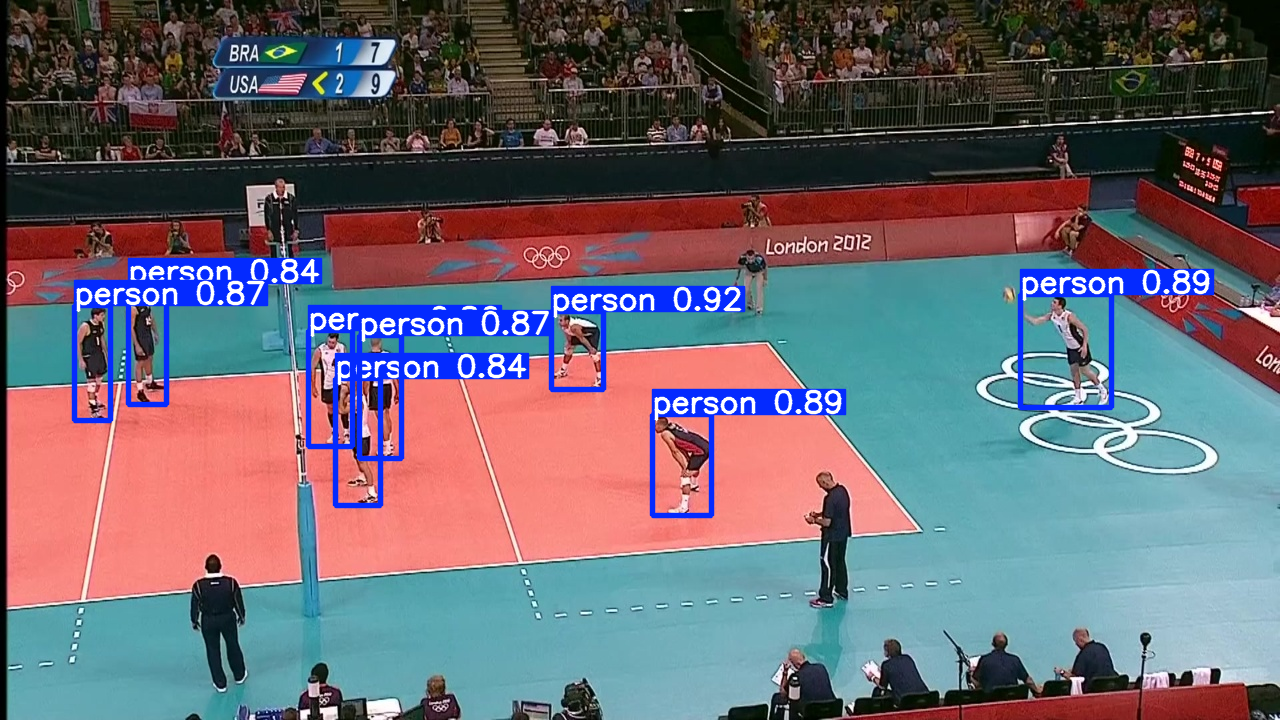

In [8]:
image_path = "/kaggle/input/sportsmot/sportsmot_publish/dataset/train/v_1LwtoLPw2TU_c016/img1/000001.jpg" # Change this to your test image

# Run inference
results = model.predict(image_path, save=True)

# Show the results
for result in results:
    result.show()  # Display the image with bounding boxes


In [10]:
!zip -r /kaggle/working/yolo_training_15_epoch.zip /kaggle/working/yolo_training_15_epoch


  adding: kaggle/working/yolo_training_15_epoch/ (stored 0%)
  adding: kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/ (stored 0%)
  adding: kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/train_batch231.jpg (deflated 10%)
  adding: kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/results.png (deflated 8%)
  adding: kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/train_batch1.jpg (deflated 3%)
  adding: kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/F1_curve.png (deflated 18%)
  adding: kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/train_batch0.jpg (deflated 4%)
  adding: kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/results.csv (deflated 60%)
  adding: kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/events.out.tfevents.1738444274.91eb820683f6.31.0 (deflated 93%)
  adding: kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/train_batch230.jpg (deflated 12%)
  adding: kaggle/working/yolo_training_15_epoch/fine_tuned_yolo/confusion_m